# Style Transfer Training

## Import Library

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T 
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

# get utils functions
from utils import grammatrix, loss_of_style, loss_of_content, content_transform, detransform_content, rescale


## Get data from images

In [63]:
# The content is the image of the user. The style is the image of the style.
# content image is stored in images/omkar.jpeg and style image is stored in images/generosity.jpeg
content_image = PIL.Image.open("images/omkar.jpg").convert('RGB')
style_image = PIL.Image.open("images/van_gogh.jpeg").convert('RGB')
style_name = 'van_gogh' # 'generosity' # 

## Get pretrained models of vgg16 and resnet18

In [3]:
# Load VGG16 model
# The VGG16 model is a pretrained CNN model that was trained on the ImageNet dataset.
vgg16 = torchvision.models.vgg16(pretrained=True).features

# Load ResNet18 model
resnet18 = torchvision.models.resnet18(pretrained=True)


In [4]:
vgg16[21]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [5]:
resnet18.layer2[1]

BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## train function for style transfer

In [64]:
# defining get_features function 
def get_features(image, model, model_name):
    '''
    Getting feature map from each layer of the model
    '''
    features = list()
    first_feature = image
    if model_name == 'vgg16':
        model = model.features
    # we add image as the input to the model
    for idx, layer in enumerate(model._modules.values()):
        image = layer(first_feature)
        features.append(image)
        first_feature = image
    return features 

In [65]:
def train_st(style, style_layer, style_weight, content, content_layer, content_weight, style_size, image_size, device, model, style_image_name, num_epochs):
    '''
    Train Style Transfer, based on Gatys' paper.
    :Input:
    - style: PyTorch tensor, style image
    - style_layer: int, index of style layer
    - style_weight: float, weight of style layer
    - content: PyTorch tensor, content image
    - content_layer: int, index of content layer
    - content_weight: float, weight of content layer
    - style_size: int, size of style image
    - image_size: int, size of image
    - device: PyTorch device
    - model: 'vgg16' or 'resnet18'
    - style_image_name: string, name of style image
    - num_epochs
    
    :Output:
    - image: PyTorch tensor, image
    '''
    # model 
    if model == 'vgg16':
        model_1 = torchvision.models.vgg16(pretrained=True).to(device)
        # model_1 doesn't require gradients
        for param in model_1.parameters():
            param.requires_grad = False
        
        # model_2 = torchvision.models.vgg16(pretrained=True).to(device)

        # # model_2 doesn't require gradients
        # for param in model_2.parameters():
        #     param.requires_grad = False
    elif model == 'resnet18':
        model_1 = torchvision.models.resnet18(pretrained=True).to(device)
        # model_1 doesn't require gradients
        for param in model_1.parameters():
            param.requires_grad = False

        # model_2 = torchvision.models.resnet18(pretrained=True).to(device)

        # # model_2 doesn't require gradients
        # for param in model_2.parameters():
        #     param.requires_grad = False

    # get style transform
    style = content_transform(style, style_size)
    # convert type of style to float
    style = style.type(torch.cuda.FloatTensor).to(device)

    # get content transform
    content = content_transform(content, image_size)
    # convert type to float
    content = content.type(torch.cuda.FloatTensor).to(device)

    # get style and content features
    content_features = get_features(content, model_1, model)
    style_features = get_features(style, model_1, model)

    # the layer on which we want the content to be 
    content_layer_output = content_features[content_layer]
    # the layers on which we want the style to be
    style_layers_output = [grammatrix(style_features[layer], True) for layer in style_layer]

    # First, initialize the image on which we want to perform style transfer with type torch.FloatTensor
    image = content.clone().type(torch.cuda.FloatTensor).requires_grad_(True).to(device)
    
    # Hyperparameters
    num_epochs = num_epochs
    learning_rate = 10
    decayed_learning_rate = 10

    # define the optimizer as Adam
    optimizer = torch.optim.Adam([image], lr=learning_rate)
    # optimizer = optim.LBFGS([opt_img])
    mse_loss = torch.nn.MSELoss().to(device)

    best_loss = float('inf')

    for epoch in range(num_epochs):
        if epoch < num_epochs-1:
            image.data.clamp_(-1.5, 1.5)
        # model train
        model_1.train()
        optimizer.zero_grad()

        # get the features of the image
        image_features = get_features(image, model_1, model)

        # get the content loss
        content_loss = content_weight * torch.sum((image_features[content_layer] - content_layer_output)**2)
        # content_loss = content_weight * mse_loss(image_features[content_layer], content_layer_output)
        # get the style loss
        style_loss = 0
        for i in range(len(style_layer)):
            style_layer_index = style_layer[i]
            layer_output = image_features[style_layer_index]
            weight = style_weight[i]
            image_grame = grammatrix(layer_output, True)
            style_gram = style_layers_output[i]
            style_loss += weight * torch.sum((image_grame - style_gram)**2)
        
        # style_loss *= style_weight
        # get athe total loss
        total_loss = content_loss + style_loss

        # perform backpropagation
        total_loss.backward(retain_graph=True)

        if epoch == 150 or epoch == 300:
            learning_rate = learning_rate/decayed_learning_rate
            optimizer = torch.optim.Adam([image], lr=learning_rate)

        # update the image
        optimizer.step()

        

        if epoch % 10 == 0:
            print("Epoch {}:".format(epoch))
            print("Content Loss: {:.4f}".format(content_loss.item()))
            print("Style Loss: {:.4f}".format(style_loss.item()))
            print("Total Loss: {:.4f}".format(total_loss.item()))
            print()

            # display the image
            plt.axis("off")
            plt.imshow(detransform_content(image.data.cpu(), image_size))
            plt.show()

            # save the checkpoint
            # if checkpoints folder doesn't exist, create it
            if not os.path.exists("checkpoints"):
                os.mkdir("checkpoints")
            # save the checkpoint of the model
            if total_loss.item() < best_loss:
                model_1.eval()
                best_loss = total_loss.item()
                # torch.save(model_1.state_dict(), "checkpoints/{}_model_{}.pth".format(style_image_name, epoch))
                # save the image in pth format
                # torch.save(image.data, "checkpoints/{}_image_{}.pth".format(style_image_name, epoch))
                print("Saved checkpoint of model and image")
        
        if best_loss > total_loss.item():
            # save the best model and image
            model_1.eval()
            best_loss = total_loss.item()
            # torch.save(model_1.state_dict(), "checkpoints/{}_model_best.pth".format(style_image_name))
            # torch.save(image.data, "checkpoints/{}_image_best.pth".format(style_image_name))

## Training

In [66]:
# parameters for train_st for vgg

parameters = dict(
    style = style_image,
    # get any layers of vgg model
    style_layer = (2, 5, 10, 17, 19),
    style_weight = [1e9/n**2 for n in (64, 128, 256, 512, 512)],
    content = content_image,
    content_layer = 2,
    content_weight = 1e-2,
    style_size = 192,
    image_size = 512,
    device = device,
    model = 'vgg16',
    style_image_name = style_name,
    num_epochs = 500
)


Epoch 0:
Content Loss: 6722.2598
Style Loss: 955666.6250
Total Loss: 962388.8750



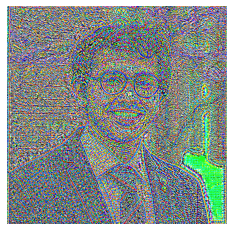

Saved checkpoint of model and image
Epoch 10:
Content Loss: 1968166.6250
Style Loss: 5573626.5000
Total Loss: 7541793.0000



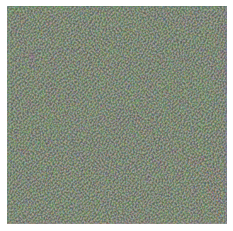

Epoch 20:
Content Loss: 1140389.5000
Style Loss: 1251726.2500
Total Loss: 2392115.7500



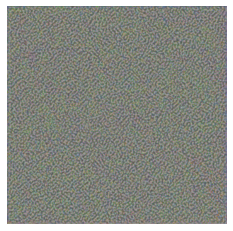

Epoch 30:
Content Loss: 718044.8125
Style Loss: 356432.5000
Total Loss: 1074477.2500



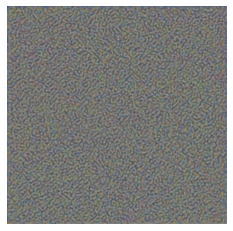

Epoch 40:
Content Loss: 480616.9375
Style Loss: 134871.7344
Total Loss: 615488.6875



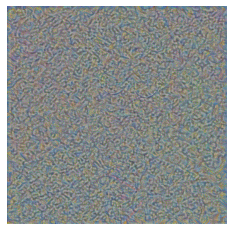

Saved checkpoint of model and image
Epoch 50:
Content Loss: 349182.0312
Style Loss: 96959.6328
Total Loss: 446141.6562



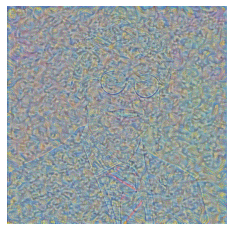

Saved checkpoint of model and image
Epoch 60:
Content Loss: 281619.7812
Style Loss: 83673.9766
Total Loss: 365293.7500



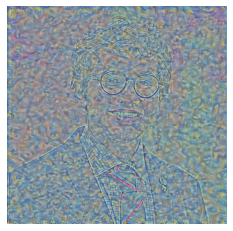

Saved checkpoint of model and image
Epoch 70:
Content Loss: 245213.7344
Style Loss: 76492.5000
Total Loss: 321706.2500



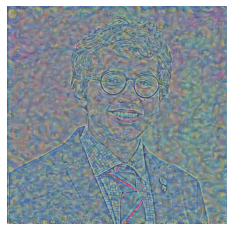

Saved checkpoint of model and image
Epoch 80:
Content Loss: 223732.1875
Style Loss: 73066.8984
Total Loss: 296799.0938



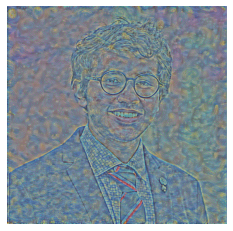

Saved checkpoint of model and image
Epoch 90:
Content Loss: 210170.9531
Style Loss: 71082.5000
Total Loss: 281253.4375



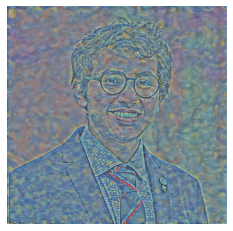

Saved checkpoint of model and image
Epoch 100:
Content Loss: 200910.7969
Style Loss: 69785.2656
Total Loss: 270696.0625



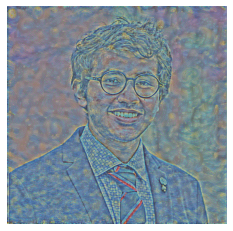

Saved checkpoint of model and image
Epoch 110:
Content Loss: 194211.1094
Style Loss: 68840.8047
Total Loss: 263051.9062



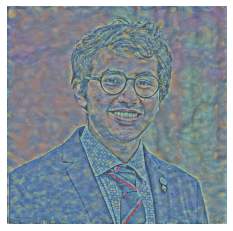

Saved checkpoint of model and image
Epoch 120:
Content Loss: 189114.0000
Style Loss: 68122.6250
Total Loss: 257236.6250



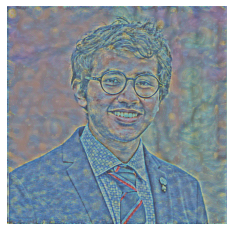

Saved checkpoint of model and image
Epoch 130:
Content Loss: 185028.0781
Style Loss: 67633.1641
Total Loss: 252661.2500



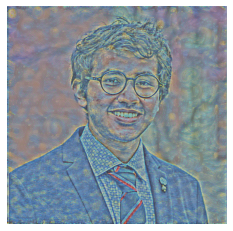

Saved checkpoint of model and image
Epoch 140:
Content Loss: 181713.5156
Style Loss: 67230.8516
Total Loss: 248944.3750



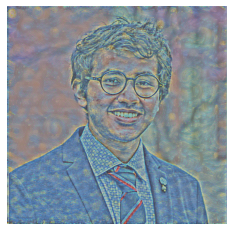

Saved checkpoint of model and image
Epoch 150:
Content Loss: 178880.8906
Style Loss: 66971.5703
Total Loss: 245852.4688



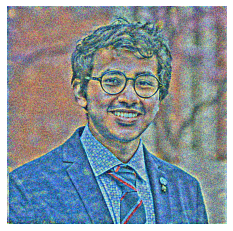

Saved checkpoint of model and image
Epoch 160:
Content Loss: 940280.3125
Style Loss: 804446.8125
Total Loss: 1744727.1250



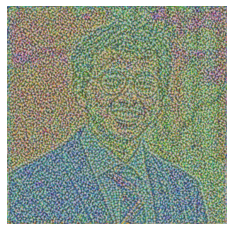

Epoch 170:
Content Loss: 541189.4375
Style Loss: 187983.4844
Total Loss: 729172.9375



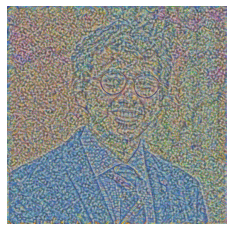

Epoch 180:
Content Loss: 359894.4688
Style Loss: 83618.2656
Total Loss: 443512.7500



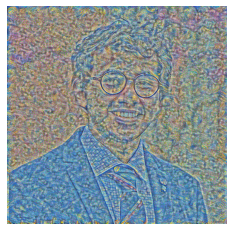

Epoch 190:
Content Loss: 276398.3438
Style Loss: 69282.1328
Total Loss: 345680.4688



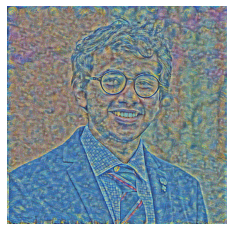

Epoch 200:
Content Loss: 230899.8125
Style Loss: 66644.0391
Total Loss: 297543.8438



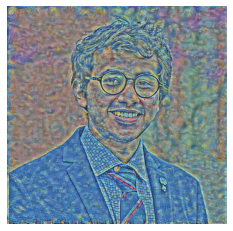

Epoch 210:
Content Loss: 206305.2188
Style Loss: 66374.9922
Total Loss: 272680.2188



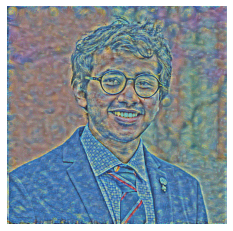

Epoch 220:
Content Loss: 192341.4375
Style Loss: 66476.7500
Total Loss: 258818.1875



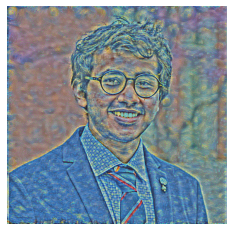

Epoch 230:
Content Loss: 183628.5156
Style Loss: 66699.1719
Total Loss: 250327.6875



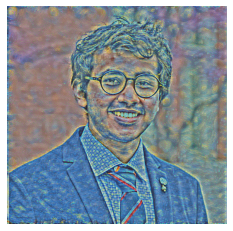

Epoch 240:
Content Loss: 178097.2188
Style Loss: 66647.8984
Total Loss: 244745.1250



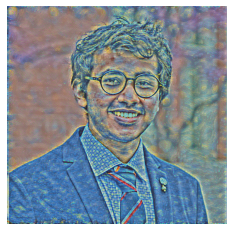

Saved checkpoint of model and image
Epoch 250:
Content Loss: 174302.5000
Style Loss: 66610.4453
Total Loss: 240912.9375



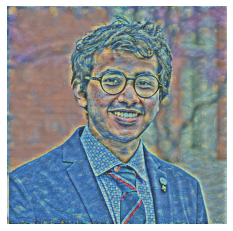

Saved checkpoint of model and image
Epoch 260:
Content Loss: 171528.2344
Style Loss: 66610.8672
Total Loss: 238139.0938



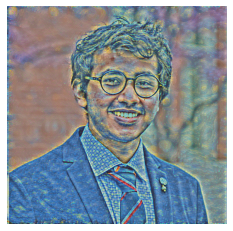

Saved checkpoint of model and image
Epoch 270:
Content Loss: 169434.7812
Style Loss: 66624.9297
Total Loss: 236059.7188



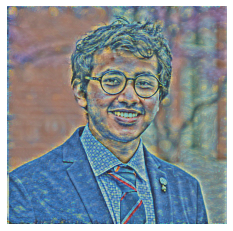

Saved checkpoint of model and image
Epoch 280:
Content Loss: 168158.7812
Style Loss: 66509.9297
Total Loss: 234668.7188



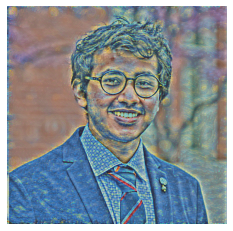

Saved checkpoint of model and image
Epoch 290:
Content Loss: 166884.9531
Style Loss: 66612.3516
Total Loss: 233497.3125



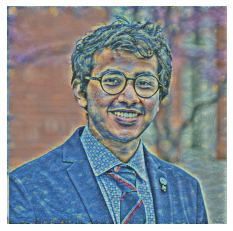

Saved checkpoint of model and image
Epoch 300:
Content Loss: 165756.4062
Style Loss: 66785.9375
Total Loss: 232542.3438



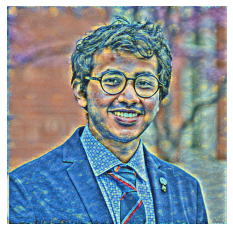

Saved checkpoint of model and image
Epoch 310:
Content Loss: 235224.3125
Style Loss: 55246.5078
Total Loss: 290470.8125



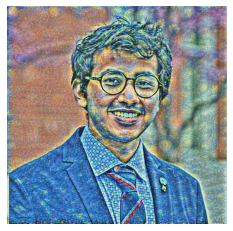

Epoch 320:
Content Loss: 192714.7969
Style Loss: 65818.6562
Total Loss: 258533.4531



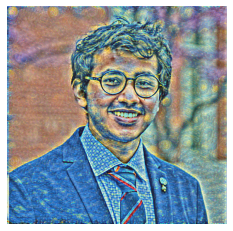

Epoch 330:
Content Loss: 177484.9531
Style Loss: 65574.8047
Total Loss: 243059.7500



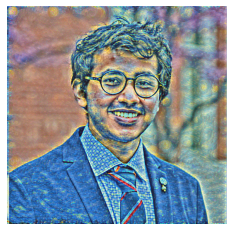

Epoch 340:
Content Loss: 169789.0156
Style Loss: 66482.2188
Total Loss: 236271.2344



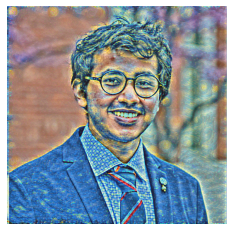

Epoch 350:
Content Loss: 166280.0000
Style Loss: 66473.5859
Total Loss: 232753.5938



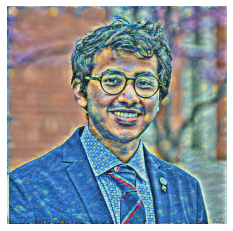

Epoch 360:
Content Loss: 164096.7500
Style Loss: 66611.4531
Total Loss: 230708.2031



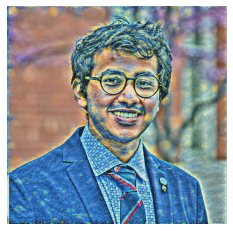

Saved checkpoint of model and image
Epoch 370:
Content Loss: 162739.4688
Style Loss: 66669.2031
Total Loss: 229408.6719



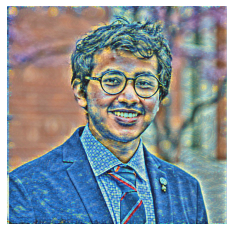

Saved checkpoint of model and image
Epoch 380:
Content Loss: 161768.0469
Style Loss: 66749.7891
Total Loss: 228517.8438



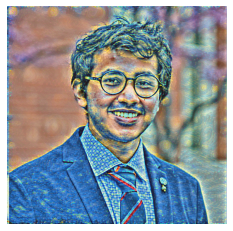

Saved checkpoint of model and image
Epoch 390:
Content Loss: 161061.3438
Style Loss: 66804.4609
Total Loss: 227865.8125



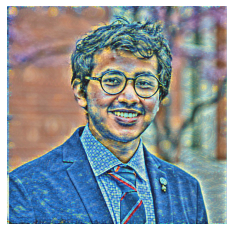

Saved checkpoint of model and image
Epoch 400:
Content Loss: 160527.5625
Style Loss: 66834.0859
Total Loss: 227361.6562



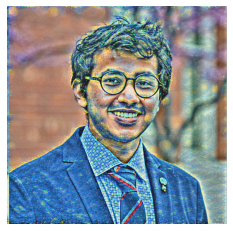

Saved checkpoint of model and image
Epoch 410:
Content Loss: 160094.9531
Style Loss: 66865.3203
Total Loss: 226960.2812



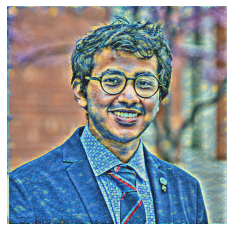

Saved checkpoint of model and image
Epoch 420:
Content Loss: 159773.3438
Style Loss: 66868.9844
Total Loss: 226642.3281



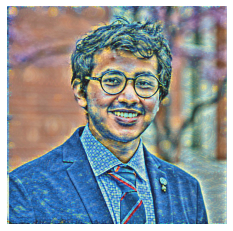

Saved checkpoint of model and image
Epoch 430:
Content Loss: 159405.8594
Style Loss: 66935.4531
Total Loss: 226341.3125



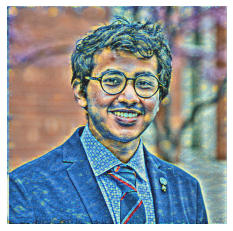

Saved checkpoint of model and image
Epoch 440:
Content Loss: 159162.9688
Style Loss: 66905.1328
Total Loss: 226068.0938



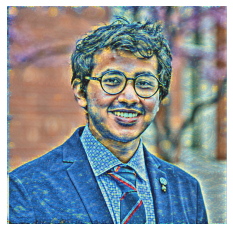

Saved checkpoint of model and image
Epoch 450:
Content Loss: 158773.9219
Style Loss: 67159.3516
Total Loss: 225933.2812



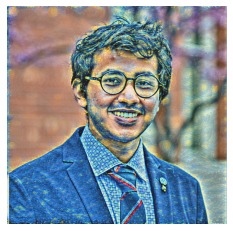

Epoch 460:
Content Loss: 158794.6562
Style Loss: 66956.0703
Total Loss: 225750.7188



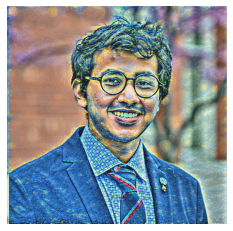

Epoch 470:
Content Loss: 158460.2969
Style Loss: 67026.2266
Total Loss: 225486.5312



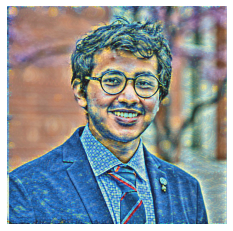

Saved checkpoint of model and image
Epoch 480:
Content Loss: 158218.0781
Style Loss: 67011.6719
Total Loss: 225229.7500



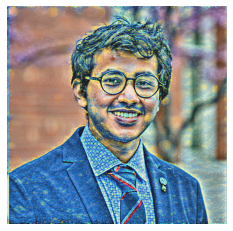

Saved checkpoint of model and image
Epoch 490:
Content Loss: 158064.8906
Style Loss: 67006.8828
Total Loss: 225071.7812



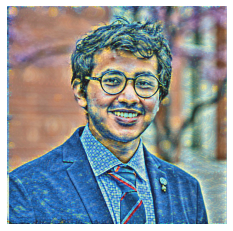

In [67]:
train_st(**parameters)

In [53]:
def stylize(image_size, content, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # get content transform
    content = content_transform(content, image_size)

    with torch.no_grad():
        # take the architecture of the model from vgg
        style_model = torchvision.models.vgg16(pretrained=False).requires_grad_(False).to(device)
        # load the model from saved pth file
        state_dict = torch.load(model, map_location=device)
        

        
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.to(device)
        style_model.eval()
        # if args.export_onnx:
        #     assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
        #     output = torch.onnx._export(
        #         style_model, content_image, args.export_onnx, opset_version=11,
        #     ).cpu()            
        # else:
        output = style_model(content).cpu()
        # display the image
        plt.axis("off")
        plt.imshow(detransform_content(output.data.cpu(), image_size))
        plt.show()
    return output


In [54]:
model = '{}_model_best.pth'.format(style_name)
stylize(192, content_image, model)

RuntimeError: ignored

In [24]:
style_name

'van_gogh'

In [42]:
model = '{}_model_330.pth'.format(style_name)
# load model from saved pth file
style_model = torchvision.models.vgg16(pretrained=False).requires_grad_(False).to(device)
state_dict = torch.load(model)
style_model.eval()

style_model.load_state_dict(state_dict)
# RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory 
# got this error. How to fix it?


FileNotFoundError: ignored